In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
import os
from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper
from Utils.transform import Binarize

dimension = (64,64)
channels = 5
optimizer = Adam( lr = 1e-5 )
tfd = tfp.distributions

def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

def mixd(output):
    rate = tf.math.exp(output[0,:,:,0]) #A 
    s = tf.math.sigmoid(output[0,:,:,1])
    components = [tfd.Deterministic(loc=tf.zeros_like(rate)), #E
     tfd.Poisson(rate=rate) #F 
     ]
    mixture = tfd.Mixture(
          cat=tfd.Categorical(probs=tf.stack([1-s, s],axis=-1)),#D
          components=components)
    
    return mixture
    
def testnetBernoulli(input_shape,
           n_predictions=1,
           simpleclassification=None,
           flatten_output=False,
           activation_hidden="relu",
           activation_output="relu"):


    inputs = Input(shape=input_shape) 

    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       # 10 x 64x64
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            # 10 x 32x32


    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  # 20 x 32x32
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            # 20 x 16x16


    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  # 20 x 16x16
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            # 20 x 8x8


    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  # 20 x 8x8
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            # 20 x 4x4


    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    # 20 x 8x8
    up04 = concatenate([conv04, up04], axis=3)  # 20+20 x 8x8


    up03 = UpSampling2D((2, 2))(up04)           # 40 x 16x16
    up03 = concatenate([conv03, up03], axis=3)  # 20+40 x 16x16


    up02 = UpSampling2D((2, 2))(up03)           # 60 x 32x32
    up02 = concatenate([conv02, up02], axis=3)  # 20+60 x 32x32


    up01 = UpSampling2D((2, 2))(up02)           # 80 x 64x64
    up01 = concatenate([conv01, up01], axis=3)  # 10+80 x 64x64


    output = Conv2D(1, (1, 1), activation=tf.exp)(up01)  # 1 x 64x64
    #output = tfkl.Flatten()(output)
    output = tfpl.IndependentBernoulli((1), tfd.Bernoulli.logits)(output)
    #outpus = tfd.Independent(tfd.Poisson(),name="image")(output)
    model = Model(inputs=inputs, outputs=output)
    return model

def provideData(flatten=False,dimension=dimension,batch_size=10,transform=None,preTransformation=None):

    getDataSet(DatasetFolder,year=[2017],username=USRN,pswd=PSWD)
    train,test = dataWrapper(PathToData,
                            dimension=dimension,
                            channels=channels,
                            batch_size=batch_size,
                            overwritecsv=True,
                            flatten=flatten,
                            onlyUseYears=[2017],
                            transform=transform,
                            preTransformation=preTransformation)
    
    return train,test
DatasetFolder = "./Data/RAW"
PathToData = os.path.join(DatasetFolder,"MonthPNGData")

Using TensorFlow backend.


Num GPUs Available: 1


In [2]:
train, test = provideData(flatten=False,dimension=dimension,batch_size=1,transform=[Binarize()],preTransformation=None)


Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 


In [3]:
t = Trainer(testnetBernoulli,
                    NLL,
                    (train,test),
                    batch_size = 1,
                    optimizer=optimizer,
                    dimension = dimension,
                    channels = channels,
                    metrics = ["mse","mae"])

print("len train,val",len(train),len(test))
t.fit(2000)

[Load file failed]  ./model_data/testnetBernoulli_function/testnetBernoulli_function64x64x5.h5
[Load file failed]  ./model_data/testnetBernoulli_function/testnetBernoulli_function64x64x5history.json
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 10)   460         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 10)   0           conv2d[0][0]                     
_____________________________________________________________________________________________

Epoch 15/2000
10/10 [==============================] - 0s 10ms/step - loss: 81.7626 - mse: 0.9483 - mae: 0.9611 - val_loss: 72.9992 - val_mse: 0.8011 - val_mae: 0.8272
Epoch 16/2000
10/10 [==============================] - 0s 10ms/step - loss: 81.7090 - mse: 0.9460 - mae: 0.9600 - val_loss: 72.9496 - val_mse: 0.7967 - val_mae: 0.8258
Epoch 17/2000
10/10 [==============================] - 0s 10ms/step - loss: 81.6585 - mse: 0.9437 - mae: 0.9589 - val_loss: 72.7647 - val_mse: 0.7906 - val_mae: 0.8226
Epoch 18/2000
10/10 [==============================] - 0s 11ms/step - loss: 81.5835 - mse: 0.9410 - mae: 0.9574 - val_loss: 72.7152 - val_mse: 0.7863 - val_mae: 0.8213
Epoch 19/2000
10/10 [==============================] - ETA: 0s - loss: 81.4511 - mse: 0.9384 - mae: 0.95 - 0s 10ms/step - loss: 81.5689 - mse: 0.9393 - mae: 0.9569 - val_loss: 72.5553 - val_mse: 0.7801 - val_mae: 0.8183
Epoch 20/2000
10/10 [==============================] - 0s 9ms/step - loss: 81.4695 - mse: 0.9361 - mae: 0.95

10/10 [==============================] - 0s 10ms/step - loss: 75.8884 - mse: 0.7113 - mae: 0.8351 - val_loss: 62.0531 - val_mse: 0.4065 - val_mae: 0.6066
Epoch 64/2000
10/10 [==============================] - 0s 10ms/step - loss: 75.7007 - mse: 0.7030 - mae: 0.8305 - val_loss: 61.6712 - val_mse: 0.3960 - val_mae: 0.5975
Epoch 65/2000
10/10 [==============================] - 0s 10ms/step - loss: 75.4360 - mse: 0.6937 - mae: 0.8250 - val_loss: 61.3283 - val_mse: 0.3871 - val_mae: 0.5898
Epoch 66/2000
10/10 [==============================] - 0s 9ms/step - loss: 75.1389 - mse: 0.6823 - mae: 0.8183 - val_loss: 60.9362 - val_mse: 0.3776 - val_mae: 0.5820
Epoch 67/2000
10/10 [==============================] - 0s 10ms/step - loss: 74.8667 - mse: 0.6720 - mae: 0.8122 - val_loss: 60.6259 - val_mse: 0.3691 - val_mae: 0.5740
Epoch 68/2000
10/10 [==============================] - 0s 11ms/step - loss: 74.5837 - mse: 0.6618 - mae: 0.8061 - val_loss: 60.2573 - val_mse: 0.3605 - val_mae: 0.5659
Epoch 6

Epoch 112/2000
10/10 [==============================] - 0s 10ms/step - loss: 58.7381 - mse: 0.1917 - mae: 0.4296 - val_loss: 48.5970 - val_mse: 0.1689 - val_mae: 0.2791
Epoch 113/2000
10/10 [==============================] - 0s 10ms/step - loss: 58.3953 - mse: 0.1845 - mae: 0.4208 - val_loss: 48.5211 - val_mse: 0.1680 - val_mae: 0.2765
Epoch 114/2000
10/10 [==============================] - 0s 10ms/step - loss: 58.1479 - mse: 0.1788 - mae: 0.4141 - val_loss: 48.3485 - val_mse: 0.1676 - val_mae: 0.2728
Epoch 115/2000
10/10 [==============================] - 0s 10ms/step - loss: 57.6625 - mse: 0.1701 - mae: 0.4024 - val_loss: 48.2256 - val_mse: 0.1657 - val_mae: 0.2685
Epoch 116/2000
10/10 [==============================] - 0s 10ms/step - loss: 57.5600 - mse: 0.1665 - mae: 0.3986 - val_loss: 48.0960 - val_mse: 0.1646 - val_mae: 0.2655
Epoch 117/2000
10/10 [==============================] - 0s 10ms/step - loss: 57.1105 - mse: 0.1587 - mae: 0.3879 - val_loss: 47.9714 - val_mse: 0.1644 - va

10/10 [==============================] - 0s 9ms/step - loss: 48.8333 - mse: 0.0428 - mae: 0.1604 - val_loss: 45.3211 - val_mse: 0.1548 - val_mae: 0.1870
Epoch 161/2000
10/10 [==============================] - 0s 9ms/step - loss: 48.7073 - mse: 0.0419 - mae: 0.1567 - val_loss: 45.2933 - val_mse: 0.1556 - val_mae: 0.1868
Epoch 162/2000
10/10 [==============================] - 0s 9ms/step - loss: 48.6512 - mse: 0.0413 - mae: 0.1550 - val_loss: 45.2720 - val_mse: 0.1558 - val_mae: 0.1863
Epoch 163/2000
10/10 [==============================] - 0s 9ms/step - loss: 48.4824 - mse: 0.0408 - mae: 0.1508 - val_loss: 45.2411 - val_mse: 0.1557 - val_mae: 0.1852
Epoch 164/2000
10/10 [==============================] - 0s 10ms/step - loss: 48.4061 - mse: 0.0397 - mae: 0.1480 - val_loss: 45.2196 - val_mse: 0.1559 - val_mae: 0.1848
Epoch 165/2000
10/10 [==============================] - 0s 9ms/step - loss: 48.3387 - mse: 0.0395 - mae: 0.1464 - val_loss: 45.1961 - val_mse: 0.1558 - val_mae: 0.1840
Epoch 

Epoch 209/2000
10/10 [==============================] - 0s 10ms/step - loss: 45.8735 - mse: 0.0276 - mae: 0.0729 - val_loss: 44.6499 - val_mse: 0.1575 - val_mae: 0.1676
Epoch 210/2000
10/10 [==============================] - 0s 11ms/step - loss: 45.8470 - mse: 0.0278 - mae: 0.0723 - val_loss: 44.6497 - val_mse: 0.1575 - val_mae: 0.1677
Epoch 211/2000
10/10 [==============================] - 0s 10ms/step - loss: 45.8090 - mse: 0.0274 - mae: 0.0709 - val_loss: 44.6382 - val_mse: 0.1575 - val_mae: 0.1673
Epoch 212/2000
10/10 [==============================] - 0s 10ms/step - loss: 45.7958 - mse: 0.0276 - mae: 0.0708 - val_loss: 44.6353 - val_mse: 0.1575 - val_mae: 0.1672
Epoch 213/2000
10/10 [==============================] - 0s 11ms/step - loss: 45.7498 - mse: 0.0275 - mae: 0.0693 - val_loss: 44.6322 - val_mse: 0.1571 - val_mae: 0.1667
Epoch 214/2000
10/10 [==============================] - 0s 10ms/step - loss: 45.7270 - mse: 0.0274 - mae: 0.0686 - val_loss: 44.6246 - val_mse: 0.1577 - va

10/10 [==============================] - 0s 10ms/step - loss: 45.0071 - mse: 0.0263 - mae: 0.0464 - val_loss: 44.4826 - val_mse: 0.1583 - val_mae: 0.1626
Epoch 258/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.9945 - mse: 0.0264 - mae: 0.0461 - val_loss: 44.4806 - val_mse: 0.1583 - val_mae: 0.1625
Epoch 259/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.9804 - mse: 0.0266 - mae: 0.0460 - val_loss: 44.4775 - val_mse: 0.1585 - val_mae: 0.1627
Epoch 260/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.9740 - mse: 0.0261 - mae: 0.0452 - val_loss: 44.4774 - val_mse: 0.1584 - val_mae: 0.1626
Epoch 261/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.9653 - mse: 0.0264 - mae: 0.0452 - val_loss: 44.4747 - val_mse: 0.1581 - val_mae: 0.1622
Epoch 262/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.9568 - mse: 0.0266 - mae: 0.0452 - val_loss: 44.4747 - val_mse: 0.1579 - val_mae: 0.1620
E

10/10 [==============================] - 0s 10ms/step - loss: 44.6824 - mse: 0.0261 - mae: 0.0362 - val_loss: 44.4221 - val_mse: 0.1587 - val_mae: 0.1609
Epoch 306/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.6793 - mse: 0.0266 - mae: 0.0367 - val_loss: 44.4216 - val_mse: 0.1584 - val_mae: 0.1605
Epoch 307/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.6733 - mse: 0.0264 - mae: 0.0363 - val_loss: 44.4208 - val_mse: 0.1582 - val_mae: 0.1603
Epoch 308/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.6706 - mse: 0.0263 - mae: 0.0361 - val_loss: 44.4194 - val_mse: 0.1591 - val_mae: 0.1611
Epoch 309/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.6687 - mse: 0.0261 - mae: 0.0358 - val_loss: 44.4196 - val_mse: 0.1581 - val_mae: 0.1602
Epoch 310/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.6630 - mse: 0.0263 - mae: 0.0359 - val_loss: 44.4184 - val_mse: 0.1586 - val_mae: 0.1606
E

10/10 [==============================] - 0s 9ms/step - loss: 44.5394 - mse: 0.0262 - mae: 0.0319 - val_loss: 44.3957 - val_mse: 0.1585 - val_mae: 0.1597
Epoch 354/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.5385 - mse: 0.0267 - mae: 0.0324 - val_loss: 44.3953 - val_mse: 0.1587 - val_mae: 0.1599
Epoch 355/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.5382 - mse: 0.0258 - mae: 0.0314 - val_loss: 44.3949 - val_mse: 0.1583 - val_mae: 0.1595
Epoch 356/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.5326 - mse: 0.0268 - mae: 0.0323 - val_loss: 44.3943 - val_mse: 0.1591 - val_mae: 0.1603
Epoch 357/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.5323 - mse: 0.0264 - mae: 0.0318 - val_loss: 44.3944 - val_mse: 0.1582 - val_mae: 0.1594
Epoch 358/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.5295 - mse: 0.0264 - mae: 0.0317 - val_loss: 44.3938 - val_mse: 0.1587 - val_mae: 0.1598
Epo

10/10 [==============================] - 0s 10ms/step - loss: 44.4685 - mse: 0.0263 - mae: 0.0297 - val_loss: 44.3822 - val_mse: 0.1587 - val_mae: 0.1595
Epoch 402/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.4664 - mse: 0.0267 - mae: 0.0301 - val_loss: 44.3819 - val_mse: 0.1589 - val_mae: 0.1596
Epoch 403/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.4664 - mse: 0.0261 - mae: 0.0294 - val_loss: 44.3819 - val_mse: 0.1586 - val_mae: 0.1593
Epoch 404/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.4651 - mse: 0.0264 - mae: 0.0297 - val_loss: 44.3816 - val_mse: 0.1583 - val_mae: 0.1590
Epoch 405/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.4640 - mse: 0.0264 - mae: 0.0297 - val_loss: 44.3814 - val_mse: 0.1587 - val_mae: 0.1594
Epoch 406/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.4644 - mse: 0.0262 - mae: 0.0295 - val_loss: 44.3812 - val_mse: 0.1587 - val_mae: 0.1594
Epoc

Epoch 450/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.4284 - mse: 0.0265 - mae: 0.0286 - val_loss: 44.3744 - val_mse: 0.1592 - val_mae: 0.1597
Epoch 451/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.4273 - mse: 0.0266 - mae: 0.0287 - val_loss: 44.3746 - val_mse: 0.1584 - val_mae: 0.1589
Epoch 452/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.4270 - mse: 0.0260 - mae: 0.0281 - val_loss: 44.3743 - val_mse: 0.1588 - val_mae: 0.1592
Epoch 453/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.4252 - mse: 0.0268 - mae: 0.0288 - val_loss: 44.3741 - val_mse: 0.1591 - val_mae: 0.1595
Epoch 454/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.4264 - mse: 0.0261 - mae: 0.0282 - val_loss: 44.3742 - val_mse: 0.1585 - val_mae: 0.1589
Epoch 455/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.4245 - mse: 0.0269 - mae: 0.0290 - val_loss: 44.3740 - val_mse: 0.1591 - val

10/10 [==============================] - 0s 10ms/step - loss: 44.4049 - mse: 0.0264 - mae: 0.0278 - val_loss: 44.3701 - val_mse: 0.1589 - val_mae: 0.1592
Epoch 499/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.4043 - mse: 0.0266 - mae: 0.0279 - val_loss: 44.3700 - val_mse: 0.1588 - val_mae: 0.1591
Epoch 500/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.4040 - mse: 0.0266 - mae: 0.0280 - val_loss: 44.3700 - val_mse: 0.1587 - val_mae: 0.1590
Epoch 501/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.4036 - mse: 0.0262 - mae: 0.0276 - val_loss: 44.3699 - val_mse: 0.1588 - val_mae: 0.1591
Epoch 502/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.4036 - mse: 0.0265 - mae: 0.0278 - val_loss: 44.3698 - val_mse: 0.1588 - val_mae: 0.1591
Epoch 503/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.4026 - mse: 0.0264 - mae: 0.0277 - val_loss: 44.3697 - val_mse: 0.1589 - val_mae: 0.1591
Ep

10/10 [==============================] - 0s 10ms/step - loss: 44.3905 - mse: 0.0264 - mae: 0.0273 - val_loss: 44.3673 - val_mse: 0.1582 - val_mae: 0.1584
Epoch 547/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3899 - mse: 0.0269 - mae: 0.0278 - val_loss: 44.3673 - val_mse: 0.1592 - val_mae: 0.1594
Epoch 548/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3902 - mse: 0.0264 - mae: 0.0273 - val_loss: 44.3673 - val_mse: 0.1586 - val_mae: 0.1588
Epoch 549/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3898 - mse: 0.0265 - mae: 0.0274 - val_loss: 44.3671 - val_mse: 0.1592 - val_mae: 0.1594
Epoch 550/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3896 - mse: 0.0263 - mae: 0.0272 - val_loss: 44.3671 - val_mse: 0.1588 - val_mae: 0.1590
Epoch 551/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3894 - mse: 0.0265 - mae: 0.0274 - val_loss: 44.3671 - val_mse: 0.1586 - val_mae: 0.1588
E

10/10 [==============================] - 0s 11ms/step - loss: 44.3814 - mse: 0.0261 - mae: 0.0268 - val_loss: 44.3655 - val_mse: 0.1588 - val_mae: 0.1589
Epoch 595/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3813 - mse: 0.0266 - mae: 0.0272 - val_loss: 44.3654 - val_mse: 0.1591 - val_mae: 0.1593
Epoch 596/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3809 - mse: 0.0264 - mae: 0.0270 - val_loss: 44.3655 - val_mse: 0.1585 - val_mae: 0.1586
Epoch 597/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3808 - mse: 0.0264 - mae: 0.0270 - val_loss: 44.3654 - val_mse: 0.1590 - val_mae: 0.1591
Epoch 598/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3808 - mse: 0.0267 - mae: 0.0273 - val_loss: 44.3654 - val_mse: 0.1587 - val_mae: 0.1588
Epoch 599/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3805 - mse: 0.0265 - mae: 0.0271 - val_loss: 44.3654 - val_mse: 0.1586 - val_mae: 0.1588
Ep

10/10 [==============================] - 0s 10ms/step - loss: 44.3750 - mse: 0.0268 - mae: 0.0272 - val_loss: 44.3643 - val_mse: 0.1593 - val_mae: 0.1594
Epoch 643/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3753 - mse: 0.0262 - mae: 0.0267 - val_loss: 44.3643 - val_mse: 0.1588 - val_mae: 0.1589
Epoch 644/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3749 - mse: 0.0269 - mae: 0.0274 - val_loss: 44.3643 - val_mse: 0.1589 - val_mae: 0.1590
Epoch 645/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3749 - mse: 0.0265 - mae: 0.0269 - val_loss: 44.3642 - val_mse: 0.1584 - val_mae: 0.1585
Epoch 646/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3748 - mse: 0.0267 - mae: 0.0271 - val_loss: 44.3642 - val_mse: 0.1588 - val_mae: 0.1589
Epoch 647/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3747 - mse: 0.0263 - mae: 0.0267 - val_loss: 44.3642 - val_mse: 0.1590 - val_mae: 0.1591
Epoc

Epoch 691/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3710 - mse: 0.0268 - mae: 0.0271 - val_loss: 44.3634 - val_mse: 0.1585 - val_mae: 0.1586
Epoch 692/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3712 - mse: 0.0258 - mae: 0.0261 - val_loss: 44.3635 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 693/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3708 - mse: 0.0268 - mae: 0.0271 - val_loss: 44.3634 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 694/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3709 - mse: 0.0267 - mae: 0.0270 - val_loss: 44.3634 - val_mse: 0.1588 - val_mae: 0.1589
Epoch 695/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3708 - mse: 0.0267 - mae: 0.0270 - val_loss: 44.3634 - val_mse: 0.1587 - val_mae: 0.1588
Epoch 696/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3707 - mse: 0.0262 - mae: 0.0265 - val_loss: 44.3634 - val_mse: 0.1588 - val_

10/10 [==============================] - 0s 10ms/step - loss: 44.3683 - mse: 0.0265 - mae: 0.0267 - val_loss: 44.3629 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 740/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3682 - mse: 0.0268 - mae: 0.0270 - val_loss: 44.3629 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 741/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3683 - mse: 0.0262 - mae: 0.0265 - val_loss: 44.3629 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 742/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3681 - mse: 0.0264 - mae: 0.0266 - val_loss: 44.3629 - val_mse: 0.1587 - val_mae: 0.1588
Epoch 743/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3681 - mse: 0.0266 - mae: 0.0268 - val_loss: 44.3629 - val_mse: 0.1593 - val_mae: 0.1594
Epoch 744/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3681 - mse: 0.0264 - mae: 0.0266 - val_loss: 44.3628 - val_mse: 0.1582 - val_mae: 0.1582
Epo

10/10 [==============================] - 0s 10ms/step - loss: 44.3663 - mse: 0.0269 - mae: 0.0270 - val_loss: 44.3625 - val_mse: 0.1593 - val_mae: 0.1594
Epoch 788/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3664 - mse: 0.0258 - mae: 0.0260 - val_loss: 44.3625 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 789/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3663 - mse: 0.0271 - mae: 0.0273 - val_loss: 44.3625 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 790/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3663 - mse: 0.0265 - mae: 0.0267 - val_loss: 44.3625 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 791/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3662 - mse: 0.0262 - mae: 0.0263 - val_loss: 44.3625 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 792/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3662 - mse: 0.0269 - mae: 0.0271 - val_loss: 44.3625 - val_mse: 0.1589 - val_mae: 0.1590
E

10/10 [==============================] - 0s 10ms/step - loss: 44.3650 - mse: 0.0260 - mae: 0.0261 - val_loss: 44.3622 - val_mse: 0.1589 - val_mae: 0.1590
Epoch 836/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3649 - mse: 0.0268 - mae: 0.0269 - val_loss: 44.3622 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 837/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3650 - mse: 0.0267 - mae: 0.0268 - val_loss: 44.3622 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 838/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3649 - mse: 0.0264 - mae: 0.0265 - val_loss: 44.3622 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 839/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3649 - mse: 0.0265 - mae: 0.0266 - val_loss: 44.3622 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 840/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3649 - mse: 0.0266 - mae: 0.0267 - val_loss: 44.3622 - val_mse: 0.1588 - val_mae: 0.1588
E

10/10 [==============================] - 0s 10ms/step - loss: 44.3640 - mse: 0.0265 - mae: 0.0266 - val_loss: 44.3620 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 884/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3640 - mse: 0.0265 - mae: 0.0266 - val_loss: 44.3620 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 885/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3640 - mse: 0.0265 - mae: 0.0266 - val_loss: 44.3620 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 886/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3640 - mse: 0.0262 - mae: 0.0263 - val_loss: 44.3620 - val_mse: 0.1584 - val_mae: 0.1585
Epoch 887/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3640 - mse: 0.0265 - mae: 0.0266 - val_loss: 44.3620 - val_mse: 0.1585 - val_mae: 0.1586
Epoch 888/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3640 - mse: 0.0264 - mae: 0.0265 - val_loss: 44.3620 - val_mse: 0.1594 - val_mae: 0.1594
Ep

10/10 [==============================] - 0s 9ms/step - loss: 44.3633 - mse: 0.0264 - mae: 0.0265 - val_loss: 44.3619 - val_mse: 0.1588 - val_mae: 0.1589
Epoch 932/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3633 - mse: 0.0265 - mae: 0.0266 - val_loss: 44.3619 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 933/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3633 - mse: 0.0266 - mae: 0.0267 - val_loss: 44.3619 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 934/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3633 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3619 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 935/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3633 - mse: 0.0267 - mae: 0.0268 - val_loss: 44.3618 - val_mse: 0.1582 - val_mae: 0.1582
Epoch 936/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3633 - mse: 0.0261 - mae: 0.0262 - val_loss: 44.3619 - val_mse: 0.1590 - val_mae: 0.1590
Ep

10/10 [==============================] - 0s 9ms/step - loss: 44.3628 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3618 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 980/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3628 - mse: 0.0271 - mae: 0.0272 - val_loss: 44.3618 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 981/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3628 - mse: 0.0262 - mae: 0.0263 - val_loss: 44.3618 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 982/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3628 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3617 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 983/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3628 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3618 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 984/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3628 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3617 - val_mse: 0.1587 - val_mae: 0.1587
Epoch

10/10 [==============================] - 0s 11ms/step - loss: 44.3625 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3617 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 1028/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3625 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3617 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 1029/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3624 - mse: 0.0270 - mae: 0.0270 - val_loss: 44.3617 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 1030/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3625 - mse: 0.0262 - mae: 0.0263 - val_loss: 44.3617 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1031/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3624 - mse: 0.0261 - mae: 0.0261 - val_loss: 44.3617 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 1032/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3624 - mse: 0.0271 - mae: 0.0272 - val_loss: 44.3617 - val_mse: 0.1588 - val_mae: 0.158

10/10 [==============================] - 0s 11ms/step - loss: 44.3622 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3616 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1076/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3622 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3616 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 1077/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3622 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3616 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 1078/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3622 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3616 - val_mse: 0.1586 - val_mae: 0.1586
Epoch 1079/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3622 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3616 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1080/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3622 - mse: 0.0261 - mae: 0.0262 - val_loss: 44.3616 - val_mse: 0.1586 - val_mae: 0.15

10/10 [==============================] - 0s 10ms/step - loss: 44.3620 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3616 - val_mse: 0.1582 - val_mae: 0.1582
Epoch 1124/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3620 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3616 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1125/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3620 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3616 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 1126/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3620 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3616 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 1127/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3620 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3616 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 1128/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3620 - mse: 0.0262 - mae: 0.0263 - val_loss: 44.3616 - val_mse: 0.1583 - val_mae: 0.1

10/10 [==============================] - 0s 10ms/step - loss: 44.3618 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1172/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3619 - mse: 0.0262 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1173/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3618 - mse: 0.0271 - mae: 0.0271 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1174/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3618 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1175/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3618 - mse: 0.0263 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1176/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3618 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.15

10/10 [==============================] - 0s 10ms/step - loss: 44.3617 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 1220/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3617 - mse: 0.0264 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1221/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3617 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 1222/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3617 - mse: 0.0264 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 1223/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3617 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1224/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3617 - mse: 0.0264 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1

10/10 [==============================] - 0s 11ms/step - loss: 44.3617 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1268/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3617 - mse: 0.0262 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1269/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3617 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 1270/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3617 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1271/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3617 - mse: 0.0258 - mae: 0.0258 - val_loss: 44.3615 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 1272/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3617 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1

10/10 [==============================] - 0s 11ms/step - loss: 44.3616 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1316/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3616 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 1317/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3616 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3615 - val_mse: 0.1594 - val_mae: 0.1594
Epoch 1318/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3616 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 1319/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3616 - mse: 0.0261 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1582 - val_mae: 0.1582
Epoch 1320/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3616 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1594 - val_mae: 0.1

10/10 [==============================] - 0s 10ms/step - loss: 44.3616 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1586 - val_mae: 0.1586
Epoch 1364/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3616 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 1365/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3616 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 1366/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3616 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 1367/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3616 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 1368/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3616 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1

10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1412/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1413/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3615 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 1414/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0261 - mae: 0.0261 - val_loss: 44.3615 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 1415/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 1416/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.15

10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0272 - mae: 0.0272 - val_loss: 44.3615 - val_mse: 0.1594 - val_mae: 0.1594
Epoch 1460/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0261 - mae: 0.0261 - val_loss: 44.3615 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 1461/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1462/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1463/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0261 - mae: 0.0261 - val_loss: 44.3615 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1464/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0270 - mae: 0.0270 - val_loss: 44.3615 - val_mse: 0.1582 - val_mae: 0.1582

10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1584
Epoch 1508/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1509/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3615 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1510/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0261 - mae: 0.0261 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1511/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1586 - val_mae: 0.1586
Epoch 1512/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0270 - mae: 0.0270 - val_loss: 44.3615 - val_mse: 0.1584 - val_mae: 0.1

10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0261 - mae: 0.0261 - val_loss: 44.3615 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 1556/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3615 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 1557/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1594 - val_mae: 0.1594
Epoch 1558/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 1559/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 1560/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1584 - val_mae: 0.15

10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0272 - mae: 0.0272 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1604/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 1605/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 1606/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1594 - val_mae: 0.1594
Epoch 1607/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1608/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1586 - val_mae: 0.1586
E

10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1652/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1653/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 1654/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 1655/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1656/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1586 - val_mae: 0.1

10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3615 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 1700/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1701/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 1702/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1592 - val_mae: 0.1592
Epoch 1703/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 1704/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1582 - val_mae: 0.15

10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1748/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 1749/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 1750/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1751/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3615 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 1752/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1

10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1796/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1797/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1798/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 1799/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0262 - mae: 0.0262 - val_loss: 44.3615 - val_mse: 0.1586 - val_mae: 0.1586
Epoch 1800/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1587

10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1584 - val_mae: 0.1584
Epoch 1844/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3615 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1845/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1846/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 1847/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 1848/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1592 - val_mae: 0.1592

10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3615 - val_mse: 0.1589 - val_mae: 0.1589
Epoch 1892/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0259 - mae: 0.0259 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1893/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0270 - mae: 0.0270 - val_loss: 44.3615 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 1894/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0265 - mae: 0.0265 - val_loss: 44.3615 - val_mse: 0.1593 - val_mae: 0.1593
Epoch 1895/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3615 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 1896/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3615 - mse: 0.0263 - mae: 0.0263 - val_loss: 44.3615 - val_mse: 0.1586 - val_mae: 0.15

10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3614 - val_mse: 0.1586 - val_mae: 0.1586
Epoch 1940/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3614 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1941/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3614 - val_mse: 0.1587 - val_mae: 0.1587
Epoch 1942/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3614 - val_mse: 0.1591 - val_mae: 0.1591
Epoch 1943/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3614 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1944/2000
10/10 [==============================] - 0s 11ms/step - loss: 44.3615 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3614 - val_mse: 0.1583 - val_mae: 0.1

10/10 [==============================] - 0s 9ms/step - loss: 44.3614 - mse: 0.0267 - mae: 0.0267 - val_loss: 44.3614 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1988/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3614 - mse: 0.0266 - mae: 0.0266 - val_loss: 44.3614 - val_mse: 0.1585 - val_mae: 0.1585
Epoch 1989/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3614 - mse: 0.0264 - mae: 0.0264 - val_loss: 44.3614 - val_mse: 0.1590 - val_mae: 0.1590
Epoch 1990/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3614 - mse: 0.0268 - mae: 0.0268 - val_loss: 44.3614 - val_mse: 0.1583 - val_mae: 0.1583
Epoch 1991/2000
10/10 [==============================] - 0s 10ms/step - loss: 44.3615 - mse: 0.0261 - mae: 0.0261 - val_loss: 44.3614 - val_mse: 0.1588 - val_mae: 0.1588
Epoch 1992/2000
10/10 [==============================] - 0s 9ms/step - loss: 44.3614 - mse: 0.0269 - mae: 0.0269 - val_loss: 44.3614 - val_mse: 0.1594 - val_mae: 0.1594

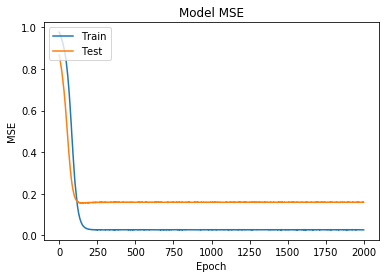

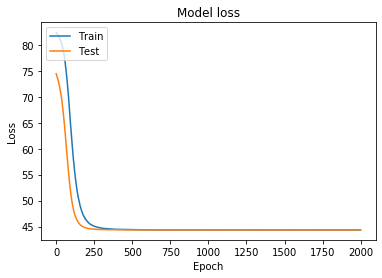

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
history = t.history
def plotHistory():
    # Plot training & validation accuracy values
    plt.plot(history['mse'])
    plt.plot(history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory()